## Time Series for Climate Change: Solar Irradiance Forecasting

- https://towardsdatascience.com/time-series-for-climate-change-solar-irradiance-forecasting-a972dac7418f
- ml기반 시계열예측 4번째 포스트

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.25</div>
<div style="text-align: right"> Last update: 2023.6.25</div>

In [1]:
import re
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
DATE_TIME_COLS = ['month', 'day', 'calendar_year', 'hour']
STATION = 'smf1'

COLUMNS_PER_FILE = \
    {'incoming_solar_final.csv': DATE_TIME_COLS + [f'{STATION}_sin_w/m2'],
     'wind_dir_raw.csv': DATE_TIME_COLS + [f'{STATION}_wd_deg'],
     'snow_depth_final.csv': DATE_TIME_COLS + [f'{STATION}_sd_mm'],
     'wind_speed_final.csv': DATE_TIME_COLS + [f'{STATION}_ws_m/s'],
     'dewpoint_final.csv': DATE_TIME_COLS + [f'{STATION}_dpt_C'],
     'precipitation_final.csv': DATE_TIME_COLS + [f'{STATION}_ppt_mm'],
     'vapor_pressure.csv': DATE_TIME_COLS + [f'{STATION}_vp_Pa'],
     'relative_humidity_final.csv': DATE_TIME_COLS + [f'{STATION}_rh'],
     'air_temp_final.csv': DATE_TIME_COLS + [f'{STATION}_ta_C'],
     }

In [3]:
data_series = {}
for file in COLUMNS_PER_FILE:
    file_data = pd.read_csv(f'data/{file}')
    
    var_df = file_data[COLUMNS_PER_FILE[file]]

    var_df['datetime'] = \
        pd.to_datetime([f'{year}/{month}/{day} {hour}:00'
                        for year, month, day, hour in zip(var_df['calendar_year'],
                                                          var_df['month'],
                                                          var_df['day'],
                                                          var_df['hour'])])
        
    var_df = var_df.drop(DATE_TIME_COLS, axis=1)
    var_df = var_df.set_index('datetime')
    series = var_df.iloc[:, 0].sort_index()

    data_series[file] = series

In [4]:
data_series


{'incoming_solar_final.csv': datetime
 2007-10-01 00:00:00    0.0
 2007-10-01 01:00:00    0.0
 2007-10-01 02:00:00    0.0
 2007-10-01 03:00:00    0.0
 2007-10-01 04:00:00    0.0
                       ... 
 2013-09-30 19:00:00    0.0
 2013-09-30 20:00:00    0.0
 2013-09-30 21:00:00    0.0
 2013-09-30 22:00:00    0.0
 2013-09-30 23:00:00    0.0
 Name: smf1_sin_w/m2, Length: 52608, dtype: float64,
 'wind_dir_raw.csv': datetime
 2007-10-01 00:00:00     261
 2007-10-01 01:00:00     278
 2007-10-01 02:00:00     303
 2007-10-01 03:00:00     274
 2007-10-01 04:00:00     304
                        ... 
 2013-09-30 19:00:00      24
 2013-09-30 20:00:00      30
 2013-09-30 21:00:00      34
 2013-09-30 22:00:00      40
 2013-09-30 23:00:00      30
 Name: smf1_wd_deg, Length: 52608, dtype: object,
 'snow_depth_final.csv': datetime
 2007-10-01 00:00:00    0
 2007-10-01 01:00:00    0
 2007-10-01 02:00:00    0
 2007-10-01 03:00:00    0
 2007-10-01 04:00:00    0
                       ..
 2013-09-30 

In [5]:
mv_series = pd.concat(data_series, axis=1)
mv_series.columns = [re.sub('_final.csv|_raw.csv|.csv', '', x) for x in mv_series.columns]
mv_series.columns = [re.sub('_', ' ', x) for x in mv_series.columns]
mv_series.columns = [x.title() for x in mv_series.columns]

mv_series = mv_series.astype(float)

In [6]:
mv_series.head()

,Incoming Solar,Wind Dir,Snow Depth,Wind Speed,Dewpoint,Precipitation,Vapor Pressure,Relative Humidity,Air Temp
datetime,,,,,,,,,
2007-10-01 00:00:00,0.0,261.0,0.0,0.5,-0.8,0.0,573.0,0.49,9.4
2007-10-01 01:00:00,0.0,278.0,0.0,0.5,-0.1,0.0,607.0,0.54,8.7
2007-10-01 02:00:00,0.0,303.0,0.0,0.5,-0.2,0.0,599.0,0.54,8.4
2007-10-01 03:00:00,0.0,274.0,0.0,0.5,-0.5,0.0,585.0,0.55,7.8
2007-10-01 04:00:00,0.0,304.0,0.0,0.6,-0.3,0.0,595.0,0.57,7.7


In [7]:
mv_series.shape

(52608, 9)

In [8]:
class LogTransformation:

    @staticmethod
    def transform(x):
        xt = np.sign(x) * np.log(np.abs(x) + 1)

        return xt

    @staticmethod
    def inverse_transform(xt):
        x = np.sign(xt) * (np.exp(np.abs(xt)) - 1)

        return x

In [9]:
mv_series_d = mv_series.resample('D').mean()
mv_series_df = mv_series_d.reset_index().melt('datetime')
mv_series_df['log_value'] = LogTransformation.transform(mv_series_df['value'])

In [10]:
mv_series_d

,Incoming Solar,Wind Dir,Snow Depth,Wind Speed,Dewpoint,Precipitation,Vapor Pressure,Relative Humidity,Air Temp
datetime,,,,,,,,,
2007-10-01,57.562500,281.583333,0.0,0.604167,1.145833,0.266667,666.958333,0.826667,4.204167
2007-10-02,164.716667,173.416667,0.0,0.595833,-0.704167,0.004167,577.333333,0.670417,6.166667
2007-10-03,129.087500,263.875000,0.0,0.758333,0.541667,0.000000,636.250000,0.607083,7.837500
2007-10-04,92.245833,209.227273,0.0,0.591667,-0.754167,0.000000,574.958333,0.704167,4.362500
2007-10-05,55.783333,234.409091,0.0,0.795833,-2.558333,0.000000,494.708333,0.761250,1.179167
...,...,...,...,...,...,...,...,...,...
2013-09-26,43.091667,137.083333,0.0,0.550000,1.645833,0.512500,689.458333,0.970000,2.079167
2013-09-27,90.929167,108.958333,0.0,0.608333,0.529167,0.000000,634.625000,0.850000,3.037500
2013-09-28,141.020833,97.250000,0.0,0.708333,0.670833,0.000000,642.125000,0.606250,9.120833


<Axes: xlabel='datetime'>

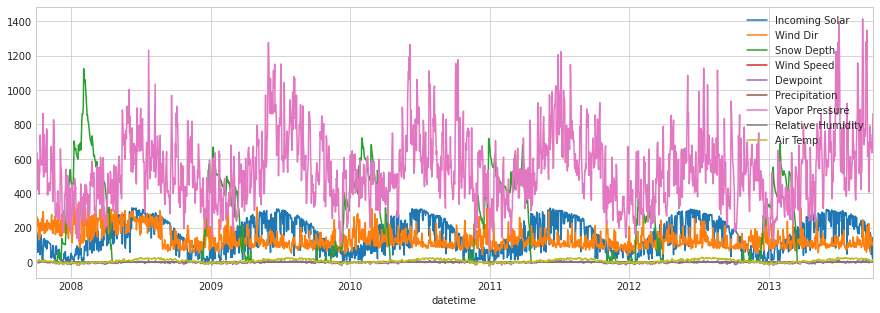

In [11]:
mv_series_d.plot(figsize = (15, 5))

<Axes: xlabel='datetime'>

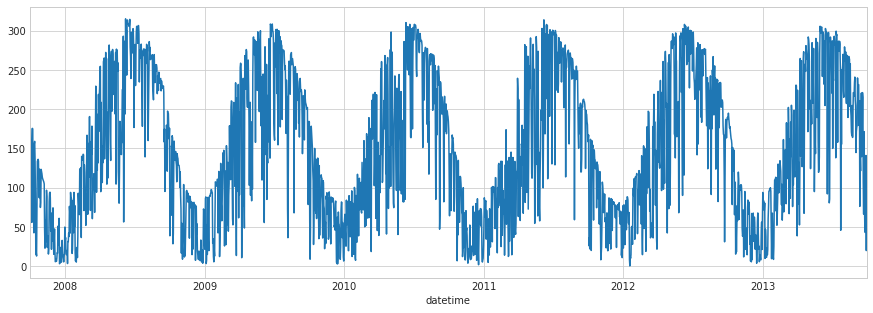

In [12]:
mv_series_d['Incoming Solar'].plot(figsize = (15, 5))

In [13]:
mv_series.head()

,Incoming Solar,Wind Dir,Snow Depth,Wind Speed,Dewpoint,Precipitation,Vapor Pressure,Relative Humidity,Air Temp
datetime,,,,,,,,,
2007-10-01 00:00:00,0.0,261.0,0.0,0.5,-0.8,0.0,573.0,0.49,9.4
2007-10-01 01:00:00,0.0,278.0,0.0,0.5,-0.1,0.0,607.0,0.54,8.7
2007-10-01 02:00:00,0.0,303.0,0.0,0.5,-0.2,0.0,599.0,0.54,8.4
2007-10-01 03:00:00,0.0,274.0,0.0,0.5,-0.5,0.0,585.0,0.55,7.8
2007-10-01 04:00:00,0.0,304.0,0.0,0.6,-0.3,0.0,595.0,0.57,7.7


In [14]:
import re

import pandas as pd
import numpy as np


def time_delay_embedding(series: pd.Series,
                         n_lags: int,
                         horizon: int,
                         return_Xy: bool = False):
    """
    Time delay embedding
    Time series for supervised learning

    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :param return_Xy: whether to return the lags split from future observations

    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    df_list = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df_list, axis=1).dropna()
    df.columns = [f'{name}(t-{j - 1})'
                  if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                  for j in n_lags_iter]

    df.columns = [re.sub('t-0', 't', x) for x in df.columns]

    if not return_Xy:
        return df

    is_future = df.columns.str.contains('\+')

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]
    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]

    return X, Y

In [15]:
def mts_to_tabular(data: pd.DataFrame,
                   n_lags: int,
                   horizon: int,
                   return_Xy: bool = False,
                   drop_na: bool = True):
    """
    Time delay embedding with multivariate time series
    Time series for supervised learning

    :param data: multivariate time series as pd.DataFrame
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :param return_Xy: whether to return the lags split from future observations

    :return: pd.DataFrame with reconstructed time series
    """

    data_list = [time_delay_embedding(data[col], n_lags, horizon)
                 for col in data]

    df = pd.concat(data_list, axis=1)

    if drop_na:
        df = df.dropna()

    if not return_Xy:
        return df

    is_future = df.columns.str.contains('\+')

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]

    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]
        
    return X, Y

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# target variable
TARGET = 'Incoming Solar'
# number of lags for each variable
N_LAGS = 24
# forecasting horizon for solar irradiance
HORIZON = 48

In [18]:
# leaving the last 30% of observations for testing
train, test = train_test_split(mv_series, test_size=0.3, shuffle=False)

# transforming the time series into a tabular format
X_train, y_train_all = mts_to_tabular(train, N_LAGS, HORIZON, return_Xy=True)
X_test, y_test_all = mts_to_tabular(train, N_LAGS, HORIZON, return_Xy=True)

# subsetting the target variable
target_columns = y_train_all.columns.str.contains(TARGET)
y_train = y_train_all.iloc[:, target_columns]
y_test = y_test_all.iloc[:, target_columns]

In [19]:
X_train.head(3)

,Incoming Solar(t-23),Incoming Solar(t-22),Incoming Solar(t-21),Incoming Solar(t-20),Incoming Solar(t-19),Incoming Solar(t-18),Incoming Solar(t-17),Incoming Solar(t-16),Incoming Solar(t-15),Incoming Solar(t-14),Incoming Solar(t-13),Incoming Solar(t-12),Incoming Solar(t-11),Incoming Solar(t-10),Incoming Solar(t-9),...,Air Temp(t-14),Air Temp(t-13),Air Temp(t-12),Air Temp(t-11),Air Temp(t-10),Air Temp(t-9),Air Temp(t-8),Air Temp(t-7),Air Temp(t-6),Air Temp(t-5),Air Temp(t-4),Air Temp(t-3),Air Temp(t-2),Air Temp(t-1),Air Temp(t)
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-10-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.5,35.4,63.8,99.4,174.5,157.9,345.8,...,2.0,2.2,3.3,4.2,3.7,4.1,5.3,6.2,6.2,5.5,2.0,0.0,-0.7,-1.1,-1.3
2007-10-02 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.5,35.4,63.8,99.4,174.5,157.9,345.8,329.8,...,2.2,3.3,4.2,3.7,4.1,5.3,6.2,6.2,5.5,2.0,0.0,-0.7,-1.1,-1.3,-1.6
2007-10-02 02:00:00,0.0,0.0,0.0,0.0,0.0,1.0,18.5,35.4,63.8,99.4,174.5,157.9,345.8,329.8,114.6,...,3.3,4.2,3.7,4.1,5.3,6.2,6.2,5.5,2.0,0.0,-0.7,-1.1,-1.3,-1.6,-1.8


In [20]:
class Holdout:
    """
    Hold-out cross-validator generator. In the hold-out, the
    data is split only once into a train set and a test set.
    Unlike in other cross-validation schemes, the hold-out
    consists of only one iteration.

    Parameters
    ----------
    n : total number of samples
    test_size : 0 < float < 1
        Fraction of samples to use as test set. Must be a
        number between 0 and 1.
    random_state : int
        Seed for the random number generator.
    """

    def __init__(self, n, test_size=0.3):
        self.n = n
        self.test_size = test_size

    def __iter__(self):
        n_test = int(np.ceil(self.test_size * self.n))
        n_train = self.n - n_test
        permutation = np.arange(self.n)
        ind_test = permutation[:n_train]
        ind_train = permutation[n_train:n_train + n_test]
        yield ind_train, ind_test

    def split(self, X=None, y=None, groups=None):
        n_test = int(np.ceil(self.test_size * self.n))
        n_train = self.n - n_test
        permutation = np.arange(self.n)

        ind_train = permutation[:n_train]
        ind_test = permutation[n_train:n_train + n_test]
        yield ind_train, ind_test

    def get_n_splits(self, *args):
        return 1

In [21]:
def correlation_filter(data: pd.DataFrame, corr_threshold: float = .9):
    # Absolute correlation matrix
    corr_matrix = data.corr().abs()

    # Create a True/False mask and apply it
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    tri_df = corr_matrix.mask(mask)

    # List column names of highly correlated features (r > 0.95)
    corr_features = \
        [c for c in tri_df.columns
         if any(tri_df[c] > corr_threshold)]

    # Drop the features in the to_drop list
    data_subset = data.drop(corr_features, axis=1)

    return data_subset

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sktime.transformations.series.date import DateTimeFeatures

In [23]:
hourly_feats = DateTimeFeatures(ts_freq='H',
                                keep_original_columns=True,
                                feature_scope='efficient')

In [24]:
hourly_feats

DateTimeFeatures(feature_scope='efficient', keep_original_columns=True,
                 ts_freq='H')

In [25]:
# building a pipeline
pipeline = Pipeline([
    # feature extraction based on datetime
    ('extraction', hourly_feats),
    # removing correlated explanatory variables
    ('correlation_filter', FunctionTransformer(func=correlation_filter)),
    # applying feature selection based on recursive feature elimination
    ('select', RFE(estimator=RandomForestRegressor(max_depth=5), step=3)),
    # building a random forest model for forecasting
    ('model', RandomForestRegressor())]
)

# parameter grid for optimization
param_grid = {
    'extraction': ['passthrough', hourly_feats],
    'select__n_features_to_select': np.linspace(start=.1, stop=1, num=10),
    'model__n_estimators': [100, 200]
}

# optimizing the pipeline with random search
model = RandomizedSearchCV(estimator=pipeline,
                           param_distributions=param_grid,
                           scoring='neg_mean_squared_error',
                           n_iter=25,
                           n_jobs=5,
                           refit=True,
                           verbose=2,
                           cv=Holdout(n=X_train.shape[0]),
                           random_state=123)

In [26]:
# running random search
model.fit(X_train, y_train)

# checking the selected model
model.best_estimator_

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END extraction=DateTimeFeatures(feature_scope='efficient', keep_original_columns=True,
                 ts_freq='H'), model__n_estimators=200, select__n_features_to_select=0.9; total time=  52.7s
[CV] END extraction=passthrough, model__n_estimators=100, select__n_features_to_select=0.7000000000000001; total time=  56.9s
[CV] END extraction=passthrough, model__n_estimators=100, select__n_features_to_select=0.6; total time= 1.1min
[CV] END extraction=passthrough, model__n_estimators=200, select__n_features_to_select=0.1; total time= 1.4min
[CV] END extraction=passthrough, model__n_estimators=200, select__n_features_to_select=0.30000000000000004; total time= 1.4min
[CV] END extraction=passthrough, model__n_estimators=200, select__n_features_to_select=0.2; total time= 1.4min
[CV] END extraction=DateTimeFeatures(feature_scope='efficient', keep_original_columns=True,
                 ts_freq='H'), model__n_estimators=100, sele

Pipeline(steps=[('extraction',
                 DateTimeFeatures(feature_scope='efficient', keep_original_columns=True,
                 ts_freq='H')),
                ('correlation_filter',
                 FunctionTransformer(func=<function correlation_filter at 0x7f44c5119b80>)),
                ('select',
                 RFE(estimator=RandomForestRegressor(max_depth=5),
                     n_features_to_select=0.6, step=3)),
                ('model', RandomForestRegressor(n_estimators=200))])

In [27]:
all_feature_names = pd.Series(model.best_estimator_['select'].feature_names_in_)

selected_features = all_feature_names[model.best_estimator_['select'].support_]
importance_scores = pd.Series(dict(zip(selected_features, model.best_estimator_['model'].feature_importances_)))

imp_df = importance_scores.reset_index()
imp_df.columns = ['Feature', 'Importance']
imp_df = imp_df.sort_values('Importance', ascending=False)
imp_df['Feature'] = pd.Categorical(imp_df['Feature'], categories=imp_df['Feature'])

In [28]:
from sklearn.metrics import mean_absolute_error as mae, r2_score

# getting forecasts for the test set
forecasts = model.predict(X_test)
forecasts = pd.DataFrame(forecasts, columns=y_test.columns)

score = {col: r2_score(y_true=y_test[col], y_pred=forecasts[col])
         for col in forecasts}

pd.Series(score)

Incoming Solar(t+1)     0.993092
Incoming Solar(t+2)     0.990019
Incoming Solar(t+3)     0.988008
Incoming Solar(t+4)     0.986634
Incoming Solar(t+5)     0.986136
Incoming Solar(t+6)     0.985797
Incoming Solar(t+7)     0.985579
Incoming Solar(t+8)     0.985430
Incoming Solar(t+9)     0.985000
Incoming Solar(t+10)    0.984866
Incoming Solar(t+11)    0.984754
Incoming Solar(t+12)    0.984668
Incoming Solar(t+13)    0.984417
Incoming Solar(t+14)    0.984114
Incoming Solar(t+15)    0.983814
Incoming Solar(t+16)    0.983690
Incoming Solar(t+17)    0.983422
Incoming Solar(t+18)    0.983265
Incoming Solar(t+19)    0.983191
Incoming Solar(t+20)    0.982854
Incoming Solar(t+21)    0.982879
Incoming Solar(t+22)    0.982568
Incoming Solar(t+23)    0.982416
Incoming Solar(t+24)    0.982108
Incoming Solar(t+25)    0.982360
Incoming Solar(t+26)    0.982300
Incoming Solar(t+27)    0.981956
Incoming Solar(t+28)    0.981827
Incoming Solar(t+29)    0.982305
Incoming Solar(t+30)    0.982059
Incoming S

In [29]:
importance_scores

Incoming Solar(t)       0.071793
Wind Dir(t-23)          0.003796
Wind Dir(t-22)          0.003526
Wind Dir(t-21)          0.003663
Wind Dir(t-20)          0.003519
Wind Dir(t-19)          0.003488
Wind Dir(t-18)          0.003394
Wind Dir(t-17)          0.003428
Wind Dir(t-16)          0.003401
Wind Dir(t-15)          0.003393
Wind Dir(t-14)          0.003521
Wind Dir(t-13)          0.003411
Wind Dir(t-12)          0.003509
Wind Dir(t-11)          0.003515
Wind Dir(t-10)          0.003464
Wind Dir(t-9)           0.003622
Wind Dir(t-8)           0.003529
Wind Dir(t-7)           0.003599
Wind Dir(t-6)           0.003599
Wind Dir(t-5)           0.003532
Wind Dir(t-4)           0.003576
Wind Dir(t-3)           0.003639
Wind Dir(t-2)           0.003796
Wind Dir(t-1)           0.004181
Snow Depth(t)           0.089653
Wind Speed(t-23)        0.002231
Precipitation(t-16)     0.000505
Precipitation(t-15)     0.000423
Precipitation(t-14)     0.000350
Precipitation(t-13)     0.000321
Precipitat